In [42]:
from IPython.display import HTML

In [43]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

<h1>Coursera - Applied Data Science Capstone

<h3><b><u>Introduction</b></u></h3>

<p>London is the capital of the United Kingdom. With a Metropolitan area spanning 3.2 thousand square miles & a population of 14 million people London exerts significant influence in areas such as finance, politics, the arts, culture & sport. Amongst this the London Underground is central to enabling London to function on a daily basis.</p>

<p>The London Underground first opened in 1863 & now operates 270 stations. With an estimates 5 million people travelling each day it is central to ensuring London functions smoothly. With such high importance proximity to a station can have a major impact on any decision.</p>

<p>My project will focus on reviewing the area around tube stations & clustering these together. This would allow those looking to expand a business to identify areas most suitable for opening</p>

<h3><b><u>Data</u></b></h3>

<h4>Station Data</h4>

<p>To get the latitude and longitude of tube stations within London I've pulled data from <a href ="https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations"> Open Street Map</a>. This data contains 302 location points though some of these are for separate parts of the same location. Where possible data used was taken from the platform to remove duplication</p>



In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.geocoders import Nominatim
import requests
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="_explorer")

plt.rcParams['figure.figsize'] = 17, 8

In [14]:
df = pd.read_html('https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations',
                 header = 0)[0]

#Map column names to lower case because I'm not a monster

df.columns = [*map(str.lower, df.columns)]

<p>As we can see the station data contains several useful fields. For this analysis we'll just be retaining name, latitude & longitude

In [15]:
df.head()

,name,latitude,longitude,platform / entrance,collected by,collected on,line,step free
0,Acton Town,51.502500,-0.278126,Platform,User:Gagravarr,24/11/06,"District, Piccadilly",NaN
1,Acton Central,51.50883531,-0.263033174,Entrance,User:Firefishy,08/05/2007,London Overground,NaN
2,Acton Central,51.50856013,-0.262879534,Platform,User:Firefishy,08/05/2007,London Overground,NaN
3,Aldgate,51.51394,-0.07537,Aldgate High Street entrance,User:Morwen,28/4/2007,Metropolitan,No
4,Aldgate East,51.51514,-0.07178,Entrance,User:Parsingphase,(2006),"District, Hammersmith & City",NaN


In [16]:
df.groupby('name')['platform / entrance'].size().reset_index(name = 'rows').sort_values('rows', ascending = False).head()

,name,rows
276,West Hampstead,4
0,Acton Central,2
285,Willesden Junction,2
240,Stratford,2
206,Richmond,2


In [17]:
df.sort_values('name', inplace = True)
df.index = range(len(df))

In [18]:
df2 = df.groupby('name').first().reset_index()[['name', 'latitude', 'longitude']]

In [19]:
df2.groupby('name').size().reset_index(name= 'rows').sort_values('rows', ascending = False);

In [20]:
tube_stations = pd.DataFrame(columns = {'station', 'longitude', 'latitude'}).reindex(['station', 'longitude', 'latitude'], 
                                                                                     axis = 1)

In [21]:
for i in range(len(df2)):
    try:
        tube_stations.loc[len(tube_stations), :] = [df2['name'].iloc[i], 
                                                    float(df2['longitude'].iloc[i]), 
                                                    float(df2['latitude'].iloc[i])]
    except:
        pass

<p>Using Folium we're able to overlay a map of London with the data points that we've collected. We can see quite clearly that central London is quite densely covered by stations. While there are some isloated stations that exist on commuter lines

In [22]:
location = geolocator.geocode('London')
latitude = location.latitude
longitude = location.longitude

london_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, station in zip(tube_stations['latitude'], tube_stations['longitude'], tube_stations['station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london_map)  
    
london_map

In [10]:
ts2 = tube_stations.copy()
ts2.columns = [_ + str(2) for _ in tube_stations.columns]
tube_stations['key'] = 0
ts2['key'] = 0

dist_check = pd.merge(tube_stations, ts2, on = 'key')

dist_check2 = dist_check[dist_check['station'] != dist_check['station2']]
dist_check2.index = range(len(dist_check2))

In [11]:
dists = pd.DataFrame(columns = ['stat1', 'stat2', 'geodesic'])

for i in range(len(dist_check2)):
    if dist_check2['station'].iloc[i] < dist_check2['station2'].iloc[i]:
    
        dists.loc[len(dists), :] = [dist_check2['station'].iloc[i],
                                dist_check2['station2'].iloc[i],
                               geodesic((dist_check2['longitude'].iloc[i], dist_check2['latitude'].iloc[i]),
                                 (dist_check2['longitude2'].iloc[i], dist_check2['latitude2'].iloc[i]))]
    else:
        dists.loc[len(dists), :] = [dist_check2['station2'].iloc[i],
                                dist_check2['station'].iloc[i],
                               geodesic((dist_check2['longitude'].iloc[i], dist_check2['latitude'].iloc[i]),
                                 (dist_check2['longitude2'].iloc[i], dist_check2['latitude2'].iloc[i]))]

In [19]:
tube_stations.drop('key', axis = 1, inplace = True)

In [14]:
CLIENT_ID = '' # your Foursquare I
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
ts_venues = getNearbyVenues(names=tube_stations['station'], 
                            latitudes=tube_stations['latitude'],
                            longitudes=tube_stations['longitude']);

#ts_venues.to_csv('tube_stations.csv', index = False)

In [25]:
ts_venues = pd.read_csv('tube_stations.csv')

ts_venues.columns = [col.lower().replace('neighborhood', 'station') for col in ts_venues.columns]

<h4>Venue Data</h4>
<p>Data for venues surrounding tube stations has been collected using the Foursquare API. This provides important information such as Venue name, category and latitude & Londitude</p>
<p>For this analysis the data has been restricted to just 100 venues within a 500m radius of the stations location

In [68]:
ts_venues.head()

,station,station latitude,station longitude,venue,venue latitude,venue longitude,venue category
0,Acton Central,51.508835,-0.263033,The Station House,51.508877,-0.263076,Pub
1,Acton Central,51.508835,-0.263033,Acton Park,51.508595,-0.261573,Park
2,Acton Central,51.508835,-0.263033,The Rocket,51.508772,-0.263787,Pub
3,Acton Central,51.508835,-0.263033,Everyone Active,51.506608,-0.266878,Gym / Fitness Center
4,Acton Central,51.508835,-0.263033,Putt in the Park,51.508583,-0.260178,Mini Golf


<h3><center>Exploratory Data Analysis</h3></center>
<p>Prior to clustering any of the data we want to get a feel for venues data by performing some simple data analysis

<p>As we'd expect stations that are in more central areas of London such as Waterloo & Camden are surrounded by a large number of venues. This is primarily to cater to tourists and the large number of businesses in the area</p>
<p>Stations outside of central London typically have less surrounding venues, this is likely down to being residential areas rather than commuter venues</p>

In [26]:
ts_venues.groupby(['station']).size().reset_index(name = 'count').sort_values('count', ascending = False).head()

,station,count
94,Goodge Street,100
223,South Kensington,100
149,Leicester Square,100
30,Brixton,100
216,Shepherd's Bush,100


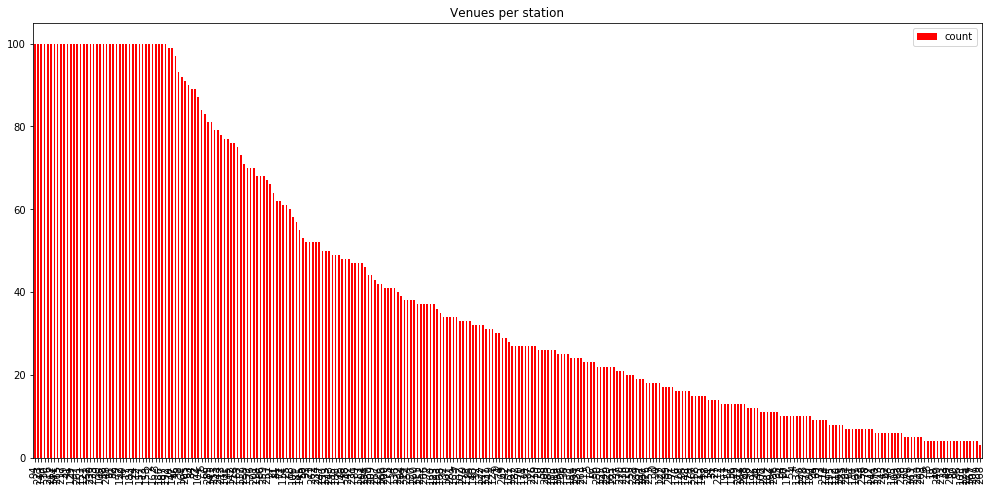

In [27]:
ts_venues.groupby(['station']).size().reset_index(name = 'count').sort_values('count', ascending = False)\
    .plot(kind = 'bar', color = 'r').set_title('Venues per station');

In [28]:
ts_v = ts_venues.groupby(['station', 'venue category']).size().reset_index(name = 'venues')\
    .sort_values(['station', 'venues'], ascending = (True, False))

In [29]:
most_common_venue = ts_v.groupby(['station']).first().reset_index()

<p>Coffee shops are the most frequent venue category within 500m of 66 stations, followed by cafes at 50 stations.

In [30]:
most_common_venue.groupby(['venue category'])['station'].nunique().reset_index().sort_values('station', ascending = False)\
    .head(10)

,venue category,station
20,Coffee Shop,66
14,Café,50
40,Pub,35
28,Grocery Store,21
31,Hotel,18
32,Indian Restaurant,10
3,Bakery,8
19,Clothing Store,8
13,Bus Stop,6
22,Convenience Store,5


<p>Stations that are situated in large tourist areas tend to display a greater variety of venue categories within the immediate radius

In [31]:
ts_venues.groupby(['station'])['venue category'].nunique().reset_index().sort_values('venue category', ascending = False)\
    .head(10)

,station,venue category
10,Baker Street,66
248,Tottenham Court Road,64
121,Holborn,63
40,Canary Wharf,63
192,Piccadilly Circus,62
30,Brixton,60
265,Warren Street,60
149,Leicester Square,60
153,London Bridge,60
216,Shepherd's Bush,60


<h2><center>Clustering stations</center></h2>

<p>To cluster each station we'll create a vector representation using venue categories. Stations will be clustered together using KMeans. As we need to specify the number of clusters we'll identify this using the Elbow method.

In [32]:
ts_total = ts_venues.groupby(['station'])['venue'].nunique().reset_index()

ts_cats = ts_venues.groupby(['station', 'venue category'])['venue'].nunique().reset_index()

ts_cats2 = ts_cats.merge(ts_total, on = ['station'], how = 'left')
ts_cats2['prop'] = np.ceil((ts_cats2['venue_x'] / ts_cats2['venue_y']))
ts_cats3 = ts_cats2.pivot(index = 'station', columns = 'venue category', values = 'prop').fillna(0)

In [33]:
ts_cats3.head()

venue category,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant
station,,,,,,,,,,,,,,,,,,,,,
Acton Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Acton Town,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aldgate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Aldgate East,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Alperton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

s = StandardScaler()
ts_cats4 = s.fit_transform(ts_cats3)

In [35]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ts_cats4)
    Sum_of_squared_distances.append(km.inertia_)

<p>Based on the Elbow plot I selected 2 different clusters for my analysis</p>

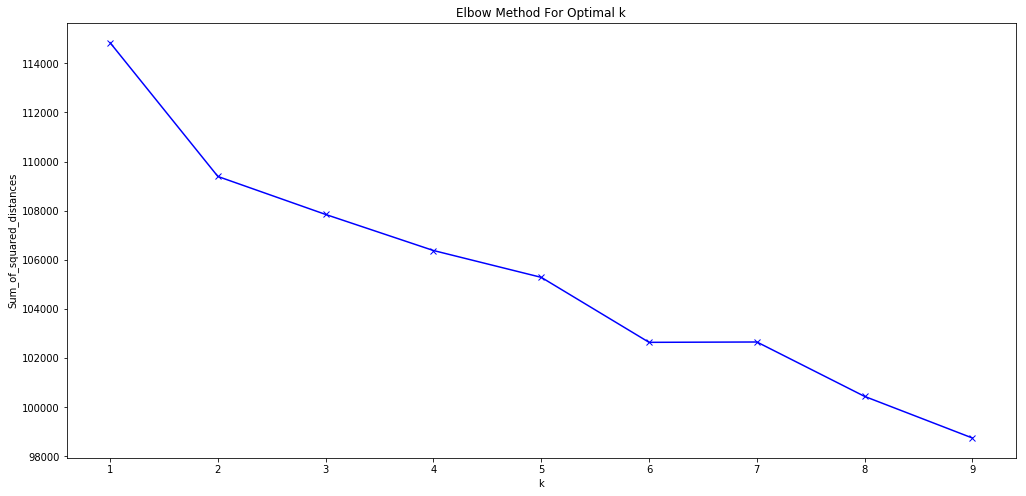

In [36]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [37]:
K = KMeans(n_clusters = 2)

In [38]:
clusts = K.fit(ts_cats4)

In [39]:
clusters = ts_cats3.reset_index().merge(pd.DataFrame(clusts.labels_, columns = ['cluster']), 
                             left_index = True, right_index = True)[['station', 'cluster']]

In [40]:
tube_stations2 = pd.merge(tube_stations, clusters, on = ['station'])

<p>After plotting the clusters we can see that one cluster seems to be predominatly covering zone 1 of London. This is generally the densest area and contains numerous shopping, entertainment and business districts</p>
<p>

In [41]:
from matplotlib import cm, colors

location = geolocator.geocode('London')
latitude = location.latitude
longitude = location.longitude

london_map = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lon, station, cluster in zip(tube_stations2['latitude'], tube_stations2['longitude'], 
                                      tube_stations2['station'], tube_stations2['cluster']):
    label = folium.Popup(str(station) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(london_map) 
    
london_map

<h3><center>Conclusions</h3></center>
<p>London tube stations appear to be effectively clustered into two groups</p>
<p>This does appear to have sound rationale as the center cluster mostly covers zone 1 which is more dense and contains shopping and business districts</p>
<p>The second clusters mostly appears to be concentrated in more residential areas</p>

<h3>Potential future analysis</h3>
<p>Extend the Foursquare area to use more data rather than just 100 merchants</p>
<p>Using house price data provided by the UK government could further enrich the clustering and provide more insight</p>
<p>Utilising the users API from Foursquare one could start to look into building connections amongst different tube stations. This would open the way for some interesting applications of Network and graphical models</p>